In [1]:
import os, sys 
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__),"..")))
sys.path.append('/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/BDT_EB4/')
from BDT_predict import * 

In [2]:
path = '/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/BDT_EB4/training_strategy_test'

path = Path(path)
training_vars = ['jet_pt', 'jet_nTracks', 'jet_trackWidth', 'jet_trackC1']
bdt_model_name = 'clf.pkl'

sample_path1 = '/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/BDT_EB4/samples/sample_testweight_testsample1'
sample_path2 = '/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/BDT_EB4/samples/sample_testweight_testsample2'

ex_name_dict ={
    'ex1': 'inclusive, no weight',
    'ex2': 'inclusive, physical weight',
    'ex3': 'inclusive, flatpt weight',
    'ex4': '1500GeV jet, physical weight',
}

identifier_name_dict = {
    'sample_testweight_testsample1':'500-600GeV',
    'sample_testweight_testsample2':'1500-2000GeV',
}

In [7]:
bdt_model_folders = sorted(path.rglob("*ex*"))

In [4]:
def plot_ROC_mod(y_decisions_dict, y_tmva, y_ntrk, target, X_weight, features, ex_name_dict, output_path, identifier, identifier_name_dict):
    # Compute ROC curve and area under the curve
    fig, ax = plt.subplots()

    for key, y_decisions in y_decisions_dict.items():
        fpr, tpr, thresholds = roc_curve(target, y_decisions, sample_weight = X_weight)
        roc_auc = auc(fpr, tpr)
        plt.plot(1-fpr, tpr, lw=1, label=f'ROC_NewTraining (area = {roc_auc:.3f}), {ex_name_dict[key]}')

    fpr_tmva, tpr_tmva, thresholds_tmva = roc_curve(target, y_tmva, sample_weight = X_weight)
    fpr_ntrk, tpr_ntrk, thresholds_ntrk =  roc_curve(target, y_ntrk, sample_weight = X_weight)

    roc_auc_tmva = auc(fpr_tmva, tpr_tmva)
    roc_auc_ntrk = auc(fpr_ntrk, tpr_ntrk)

    plt.plot(1-fpr_tmva, tpr_tmva, lw=1, label='ROC_oldBDT (area = %0.3f)'%(roc_auc_tmva))
    plt.plot(1-fpr_ntrk, tpr_ntrk, lw=1, label='ROC_Ntrk (area = %0.3f)'%(roc_auc_ntrk))

    plt.plot([0, 1], [1, 0], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC with features:{features}'+r" physical $p_{T}$ weight"+f",{identifier_name_dict[identifier]}")
    plt.legend(loc="lower left")
    plt.grid()
    plt.savefig(os.path.join(output_path, f"ROC_{identifier}.png"))
    plt.show()


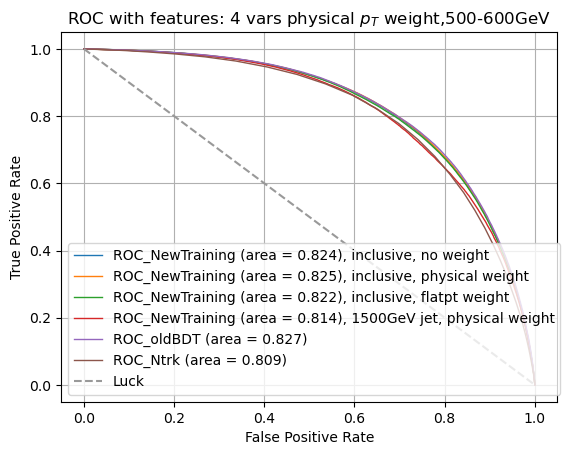

<Figure size 640x480 with 0 Axes>

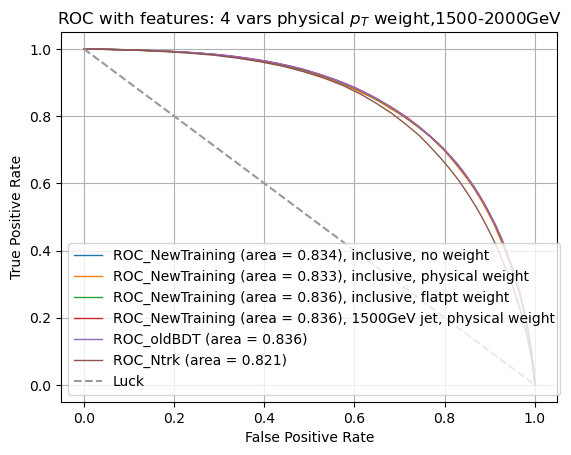

                                jet_pt  jet_nTracks  jet_trackWidth  \
inclusive, no weight          0.105251     0.783838        0.018562   
inclusive, physical weight    0.028008     0.878965        0.023710   
inclusive, flatpt weight      0.122120     0.777396        0.035600   
1500GeV jet, physical weight  0.008559     0.918604        0.044547   

                              jet_trackC1  
inclusive, no weight             0.092349  
inclusive, physical weight       0.069317  
inclusive, flatpt weight         0.064885  
1500GeV jet, physical weight     0.028290  


<Figure size 640x480 with 0 Axes>

In [8]:
feature_importance_dict = {}
for sample_path in [sample_path1, sample_path2]:
# sample_path=Path(sample_path2)
    sample_path = Path(sample_path)
    test_sample = pd.read_pickle(sample_path)

    y_test = test_sample['target']
    X_test = test_sample.drop(['target'], axis = 1)

    y_test_decisions_dict = {}
    for bdt_model_folder in bdt_model_folders:
        bdt_path = bdt_model_folder / bdt_model_name 
        with open(bdt_path, 'rb') as f:
            bdt = pickle.load(f)
        feature_importance_dict[bdt_model_folder.stem] = bdt.feature_importances_

        y_test_decisions_dict[bdt_model_folder.stem] = bdt.decision_function(X_test[training_vars])

    plot_ROC_mod(y_test_decisions_dict, y_tmva=X_test.iloc[:,X_test.columns.get_loc('jet_trackBDT')], 
                    y_ntrk=X_test.iloc[:,X_test.columns.get_loc('jet_nTracks')], target=y_test, 
                    X_weight=X_test['event_weight'], features=" 4 vars", ex_name_dict = ex_name_dict,
                    output_path=bdt_model_folder.parent.as_posix(), identifier = sample_path.stem, 
                    identifier_name_dict = identifier_name_dict)

feature_importance_pd = pd.DataFrame(feature_importance_dict.values(), index=ex_name_dict.values(), columns =training_vars)
print(feature_importance_pd)
feature_importance_pd.to_pickle(f'feature_importance.pkl')

In [ ]:
feature_importance_pd